<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%5B6%5D%EA%B3%A0%EA%B0%9D%EB%93%B1%EA%B8%89%EC%98%88%EC%B8%A1_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고객의 이미지로 등급을 예측하여 보자

In [1]:
## 필요한 라이브러리 불러오기
import pandas as pd; import numpy as np; from keras.models import Sequential; from keras.layers import Dense, Dropout, Activation; import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split; from keras.utils.np_utils import to_categorical;  from matplotlib import style
import cv2; from google.colab.patches import cv2_imshow

!git clone https://github.com/hongjai-rhee/public.git

Using TensorFlow backend.


fatal: destination path 'public' already exists and is not an empty directory.


In [0]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function; from torch import nn, optim, cuda, tensor
from torch.utils import data; from torchvision import datasets, transforms
import torch.nn.functional as F ; import time

# ‘customer1500.csv’ 파일을 구글 드라이브에 마운트 한 다음 데이터 파일을 불러오자




In [22]:
dat = tensor(np.array(pd.read_csv('customer1500.csv')))
dat.shape

torch.Size([1499, 65])

# 데이터 로드를 학습

In [11]:
dat = tensor(np.array(pd.read_csv('customer1500.csv')))

y=dat[:,0]; x=dat[:,1:65] # x= image(8*8), y=고객상태 label
x=tensor(x); y=tensor(y)


train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())    

# Data Loader (배치 사이즈에 맞도록 데이터 정리)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=batch_size, shuffle=False)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [12]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Training MNIST Model on {device}\n{"=" * 44}')

Training MNIST Model on cuda


# x는 고객의 특성을 64개의 숫자벡터로 표현한 것이다.
# 특성은 인구통계학적 특성, 구매이력, 또는 사진 등이 될 수 있다

In [16]:
print(x[1])  ## 1번 고객의 특성 벡터
x.shape

tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1])


torch.Size([1499, 64])

# y는 각 고객이 어떤 등급에 속하는지 나타내는 레이블이다. 
 
 	0= buy none
 	1= buy small
 	2= buy big

In [14]:
print(y[0:100])


tensor([0, 2, 0, 1, 0, 2, 1, 0, 2, 1, 2, 2, 2, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2,
        1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1,
        2, 2, 0, 2, 1, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 2, 2, 2, 1, 1,
        2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1,
        0, 2, 1, 1])


# 고객의 특성을 시각화하여 보자. 
얼굴이미지도 동일하게 처리 가능하다. 어떻게 생긴 고객이 우리 제품 구매가능성이 더 높을까? ㅎㅎ  


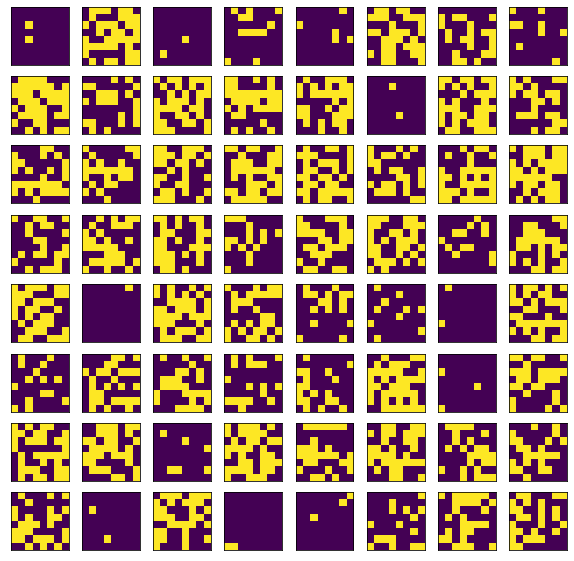

In [15]:
# 이미지 벡터 시각화
z = x.reshape(1499, 8,8)
plt.figure(figsize=(10,10))
for i in range(64) :
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(z[i])
plt.show()

# 딥러닝 파라미터 설정

In [0]:
# 이제 전과 같이 딥러닝 파라미터를 정의하자

EPOCH=70; BATCH=32  ## 학습횟수 
batch_size = 64
class_names = ['buy NONE', 'buy SMALL', 'buy BIG']   
 


# 모형 설정

In [0]:
class Net(nn.Module):

    def __init__(self):    ## 레이어 구조 설정 (뉴론의 수)
        super(Net, self).__init__()
        self.l1 = nn.Linear(64, 32)   ## 인풋레이어        
        self.l2 = nn.Linear(32, 3)   ## 히든 1
        
    def forward(self, x):  ## 연산방법과 활성화함수 설정
        #x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        return self.l2(x)               ## no softmax here

model = Net()
model.to(device)   ## GPU 지정

criterion = nn.CrossEntropyLoss()    ## 손실함수 지정
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)   ## 최적화모듈 지정


In [0]:

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')

# 모델성능 시각화하기

# 신규고객의 이미지를 입력하여, 확률적인 등급예측을 해보자.

In [0]:
for epoch in range(EPOCH):
      train(epoch)
      test()

고객 특성


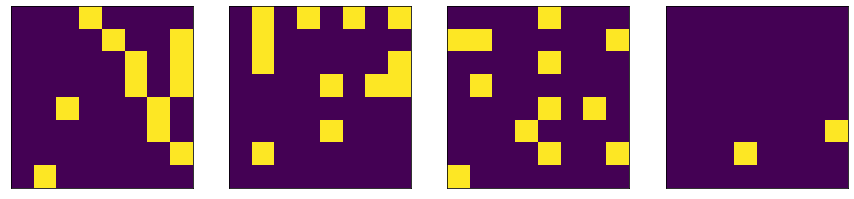

고객 유형 예측


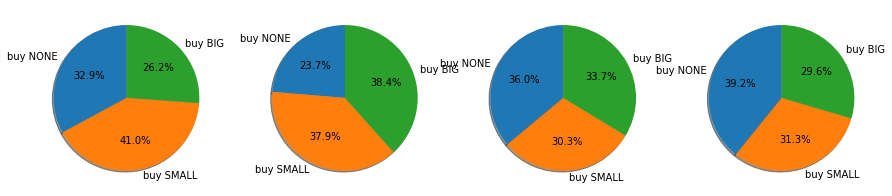

In [0]:
# 예측하기 
x_new= x_test; yhat = model.predict(x_new)
z_new =x_new.reshape(x_new.shape[0], 8,8)
print('고객 특성')
plt.figure(figsize=(15,15))
for i in range(4) :
    plt.subplot(1,4,i+1); plt.xticks([]);plt.yticks([]);plt.grid(False); plt.imshow(z_new[i])
plt.show()
print('고객 유형 예측')
plt.figure(figsize=(15,15))
for i in range(4) :
    plt.subplot(1,4, i+1); plt.xticks([]);plt.yticks([]);plt.grid(False); 
    ratio = yhat[i]; plt.pie(ratio, labels=class_names, shadow=True, startangle=90, autopct='%0.1f%%');   
plt.show()

#EOF

# 어떤 고객이 가장 우수한 것으로 예측되는가? 
이 방법을 응용하면 무엇을 할 수 있을지 곰곰이 생각해봅시다. 